In [1]:
#import warnings
#warnings.filterwarnings("ignore")
from __future__ import print_function, division
%matplotlib inline
import time
import tqdm
from tqdm import tqdm_notebook as tqdm_notebook
from tqdm import trange
import logging
from collections import OrderedDict
logger = logging.getLogger(__name__)

# Your code goes here
import os
import subprocess
from pathlib import Path
import numpy as np
from numpy import testing
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
import seaborn as sns

from sklearn.metrics import adjusted_rand_score, confusion_matrix
from sklearn.preprocessing import StandardScaler, Normalizer

import metric_learn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import DistanceMetric
from sklearn.neighbors.ball_tree import BallTree
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss

# Shogun - Metric Learning
from shogun import LMNN as shogun_LMNN
from shogun import RealFeatures, MulticlassLabels
from sklearn.utils.validation import check_X_y, check_array

# POT imports
import ot
from ot.datasets import get_1D_gauss as gauss

# MML import 
from mml import wasserstein, transform, gml, ot_testing, datasets, helper

data_path = str(Path(os.getcwd())) + "/data/"
multiclass_path = str(Path(os.getcwd())) + "/results/multiclass/"
binary_path = str(Path(os.getcwd())) + "/results/binary/"

def write_to_pickle(dataframe, name):
    dataframe.to_pickle(data_path + name + ".pickle")
def read_from_pickle(name): 
    return pd.read_pickle(data_path + name + ".pickle")

# 1D Barycenter example
- Take 2 gaussians and average them using OT. The support of the Gaussians is the same. 
- I need to take a grid of position dependent distributions (the spiking ones) and average them such that I can get x,y position of the "average" distribution

In [2]:
from matplotlib.collections import PolyCollection 
import scipy as sp

In [62]:
#%% parameters
n = 100

# bin positions
x = np.arange(n, dtype=np.float64)

# Gaussian distributions
a1 = gauss(n, m=20, s=5)  
a2 = gauss(n, m=60, s=8)

In [63]:
# creating matrix A containing all distributions 
# What is the support? 
A = np.vstack((a1, a2)).T
n_distributions = A.shape[1]

In [64]:
# loss matrix + normalization - why the normalization!? 
# Standard euclidean
M = ot.utils.dist0(n)
M /= M.max()

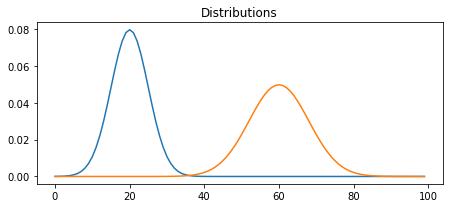

In [65]:
#%% plot the distributions on the same axis - I need an x,y grid
pl.figure(1, figsize=(6.4, 3))
for i in range(n_distributions):
    pl.plot(x, A[:, i])
pl.title('Distributions')
pl.tight_layout()

In [55]:
step = 50
avg = []
for i in range(0,n-step,1): 
    avg.append((0.8*a1[i:i+step].sum() + 0.2*a2[i:i+step].sum()))

## Compute 1D Barycenter

- Find the best way to choose the regularizing parameter 1e-4 fails


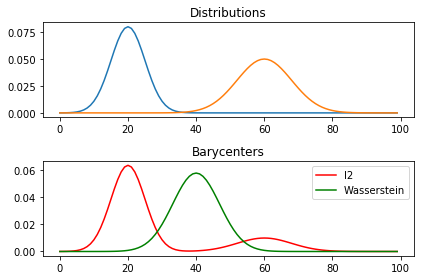

In [72]:
#%% barycenter computation
alpha = 0.2  # 0<=alpha<=1 
# These the weights associated with each distribution gives .8 mass to first one and .2 to second one
weights = np.array([1- alpha,alpha]) 

# l2bary - minimizer over the sum, with weight coefficients. 
bary_l2 = A.dot(weights)

# wasserstein with Sinkhorn and Bregman
reg = 1e-3
bary_wass = ot.bregman.barycenter(A, M, reg, None)

pl.figure(2)
pl.clf()
pl.subplot(2, 1, 1)
for i in range(n_distributions):
    pl.plot(x, A[:, i])
pl.title('Distributions')

pl.subplot(2, 1, 2)
pl.plot(x, bary_l2, 'r', label='l2')
pl.plot(x, bary_wass, 'g', label='Wasserstein')
pl.legend()
pl.title('Barycenters')
pl.tight_layout()

## Barycentric interpolation 
 - Only ideas, the code and images are from POT
 - You take the same 2 gaussians and plot 11 possibilities of interpolation using a) L2 and b) W2 for various values for $\alpha$ which gives you the weights

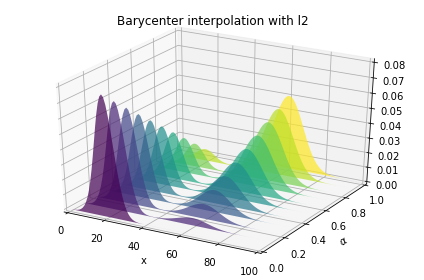

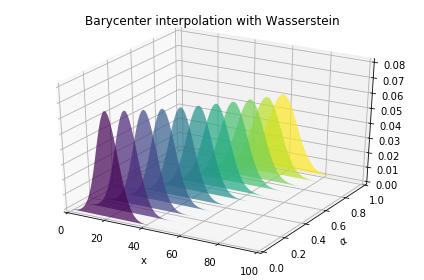

In [73]:
#%% barycenter interpolation

n_alpha = 11
alpha_list = np.linspace(0, 1, n_alpha)


B_l2 = np.zeros((n, n_alpha))

B_wass = np.copy(B_l2)

for i in range(0, n_alpha):
    alpha = alpha_list[i]
    weights = np.array([1 - alpha, alpha])
    B_l2[:, i] = A.dot(weights)
    B_wass[:, i] = ot.bregman.barycenter(A, M, reg, weights)

#%% plot interpolation

pl.figure(3)

cmap = pl.cm.get_cmap('viridis')
verts = []
zs = alpha_list
for i, z in enumerate(zs):
    ys = B_l2[:, i]
    verts.append(list(zip(x, ys)))

ax = pl.gcf().gca(projection='3d')

poly = PolyCollection(verts, facecolors=[cmap(a) for a in alpha_list])
poly.set_alpha(0.7)
ax.add_collection3d(poly, zs=zs, zdir='y')
ax.set_xlabel('x')
ax.set_xlim3d(0, n)
ax.set_ylabel('$\\alpha$')
ax.set_ylim3d(0, 1)
ax.set_zlabel('')
ax.set_zlim3d(0, B_l2.max() * 1.01)
pl.title('Barycenter interpolation with l2')
pl.tight_layout()

pl.figure(4)
cmap = pl.cm.get_cmap('viridis')
verts = []
zs = alpha_list
for i, z in enumerate(zs):
    ys = B_wass[:, i]
    verts.append(list(zip(x, ys)))

ax = pl.gcf().gca(projection='3d')

poly = PolyCollection(verts, facecolors=[cmap(a) for a in alpha_list])
poly.set_alpha(0.7)
ax.add_collection3d(poly, zs=zs, zdir='y')
ax.set_xlabel('x')
ax.set_xlim3d(0, n)
ax.set_ylabel('$\\alpha$')
ax.set_ylim3d(0, 1)
ax.set_zlabel('')
ax.set_zlim3d(0, B_l2.max() * 1.01)
pl.title('Barycenter interpolation with Wasserstein')
pl.tight_layout()

pl.show()

# Gromov Wasserstein
- Find distances between distributions defined on different metric spaces, i.e. distance between 2D and 3D